<a href="https://colab.research.google.com/github/junwin/housePriceJs/blob/main/modelTraining/house_price_predictionData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A  regression model for house prices using Keras and Tensorflow for use in Web pages

TensorFlow provides a rich set of options to train and develop and test models then deploy them to different environments.

The following code trains a simple regression model based on housing prices using Tensorflow and Keras. 

To make inferences in JavaScript, we will use TensorFlow JS to convert from Python to one that JavaScript can use.

The approach is similar to the sample I produced using ML.Net from Microsoft: https://towardsdatascience.com/predicting-a-house-price-using-ml-net-6555ff3caeb

We will run the code in Google's Colaboratory since this provides an excellent environment that allows access to GPU's, requires no configuration, and enables sharing.

Be aware that there is a regional bias in the data since all the test data came from a few areas of Chicago's northern suburbs.

## Dependencies
First, let's load any dependencies required.

In [65]:
#@title Dependancies
import pandas as pd

# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
from tensorflow.keras import regularizers
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math


## Let's load a dataset of house sales. 
We need to sanity test the raw data we loaded to ensure the columns are in the date range we expect. It is a good idea to check the data for any outliers; for example, in my first iteration, one home had 82 garage spots. Be aware that there is a regional bias in the data since all the test data came from a few areas of Chicago's northern suburbs.I will apply some crude normailzaton to the price and area columns.

Notice tha the data has the property type already one hot encoded.


In [66]:
url="https://junwin.github.io/data/cleanData.csv"
housePrices=pd.read_csv(url).sample(frac=1)


prices = housePrices.pop('SoldPr') / 1000000
housePrices['Area'] = housePrices['Area']/1000
housePrices.head()


,SFH,Condo,Duplex,Townhouse,New,Recent,20A,19A,19B,19C,19D,Pre1900,Area,Rooms,FullBaths,HalfBaths,BsmtBth,Beds,BsmtBeds,GarageSpaces,60002,60025,60026,60029,60035,60053,60062,60067,60076,60077,60091,60201,60202,60203,60625,60626,60638,63104
3736,1,0,0,0,0,0,1,0,0,0,0,0,3.043,8,2,1,0,3.0,0,2.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3399,1,0,0,0,0,0,0,1,0,0,0,0,1.637,8,2,0,0,4.0,0,1.1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3417,0,1,0,0,0,0,0,1,0,0,0,0,1.350,5,2,0,0,2.0,0,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2000,1,0,0,0,0,0,0,1,0,0,0,0,1.321,7,1,1,0,3.0,0,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5329,0,0,0,1,0,0,0,1,0,0,0,0,1.055,7,1,1,0,3.0,0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## Features
Let's grab the features we want to model; the good thing is that its relatively easy to experiment with different features using pandas.

In [67]:
SAMPLES = len(housePrices.index)
featureCount = len(housePrices.columns)


### Understanding the input data
It is imperative to have a good overview of the model's data, so you need to plot some of the features to check any issues. Suppose you look at the first plot of the area against price:
* there are many issues as the area increases. 
* most of the data is for smaller homes.

I am not going to address these issues here, but the input merits some scrutiny.


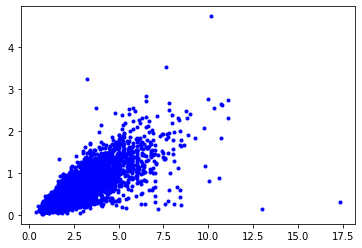

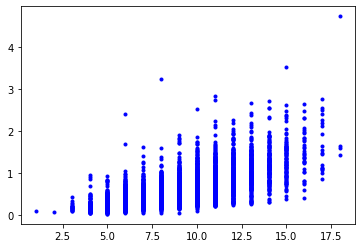

In [68]:
# Plot our data to examine the relationship between some features and price
plt.plot(housePrices['Area'], prices, 'b.')
plt.show()
plt.plot(housePrices['Rooms'], prices, 'b.')
plt.show()


## Separate data
We need to split our data into two parts, the first 50% is for training, the rest are used for for validation. 

In [69]:
TRAIN_SPLIT =  int(0.5 * SAMPLES)

training_examples = housePrices.head(TRAIN_SPLIT)
training_targets = prices.head(TRAIN_SPLIT)

validation_examples = housePrices[TRAIN_SPLIT:-1]
validation_targets = prices[TRAIN_SPLIT:-1]




#Create TensorFlow datasets for training and validaton.
Datasets are conveient and provide features like shuff;e and setting a bathc size when training.
Here we will convert the raw data into Datasets.


In [70]:
dataset = tf.data.Dataset.from_tensor_slices((training_examples.values, training_targets .values))
train_dataset = dataset.shuffle(len(training_examples)).batch(10)

dataset2 = tf.data.Dataset.from_tensor_slices((validation_examples.values, validation_targets .values))
validation_dataset = dataset2.shuffle(len(validation_examples)).batch(1)



## Training a model using Keras
Now we have our data; we can use Keras (a high-level API to Tensorflow) to create a model.
 Keras makes it easy to experiment with different model architectures and visualize the results.

We will begin with three layers and use the "relu" activation function. Notice that the final layer outputs to a single neuron since it's the predicted price and that we are using regularization to reduce overfitting.


In [ ]:
model_1 = tf.keras.Sequential()

model_1.add(keras.layers.Dense(42, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_1.add(keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(train_dataset,  epochs=50, batch_size=128,
                        validation_data=(validation_dataset))


### Understanding the results
Having trained our model, we now need to check the training metrics to see how the model converges. First, we will check out training over all the epochs, then show a graph that excludes some of the initial epochs to focus on whats happening nearer the end.

We can see a very rapid convergence, where the loss flattens out after about 10 epochs. On the second plot, it looks like a reasonable difference between the training and validation loss.


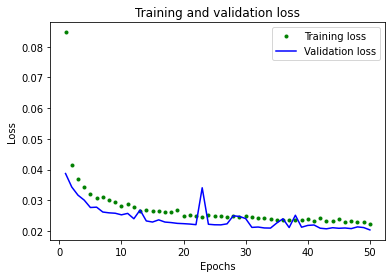

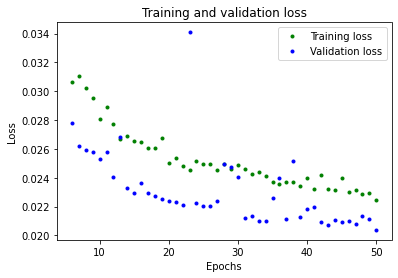

In [72]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 5

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Saving a model for later use in a web page
Now that we have a working model, we will save it.
We will then use the model without further training.

To use the model in a web page we can use a converter in the TensorFlowJs  import.

This saves the model and the data so that they can be used from JavaScript for interences.

In [ ]:
keras.models.save_model(model_1, 'housePriceModel2.hp5', True)
! zip -r hpmodel.zip housePriceModel2.hp5 *.*

! pip install tensorflowjs
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model_1, 'tensorFlowJs')
! zip -r hpmodelJs.zip tensorFlowJs

# Loading a model
Let's load the scalers, encoders and model and predict prices using the model we loaded; the indicated prices should be the same as above.

In [60]:
#! unzip  /content/hpmodel.zip


model_2 = keras.models.load_model("housePriceModel2.hp5")


In [61]:
singleFeature  = training_examples.values[0]
print(singleFeature)
singleFeature = singleFeature.reshape(1,38)
model_1.predict(singleFeature)

[ 1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  5. 13.  3.  1.  1.  4.
  0.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


array([[0.4558676]], dtype=float32)